In [1]:
import theano.tensor as T 
import theano
import numpy
from theano.tensor.nnet import relu,conv2d
import h5py
from theano.tensor.signal.pool import pool_2d
import numpy as np
import scipy.optimize
import skimage.transform
%matplotlib inline
import matplotlib.pyplot as plt

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5005)


In [2]:
class ConvLayer(object):
	"""Convolutional layer"""

	def __init__(self, rng, input, filter_shape, image_shape, W=None, b=None, padding=(1,1),filter_flip=True):
		"""
		Allocate a LeNetConvPoolLayer with shared variable internal parameters.

		:type rng: numpy.random.RandomState
		:param rng: a random number generator used to initialize weights

		:type input: theano.tensor.dtensor4
		:param input: symbolic image tensor, of shape image_shape

		:type filter_shape: tuple or list of length 4
		:param filter_shape: (number of filters, num input feature maps,
		                      filter height, filter width)

		:type W: in accordance to filter_shape
		:param: use pretrained VGG weights

		:type b: (filter_shape[0],)
		:param: use pretrained vgg weights

		:type image_shape: tuple or list of length 4
		:param image_shape: (batch size, num input feature maps,
		                     image height, image width)

		:type padding: tuple or list of length 2
		:param padding: padding for conv
		"""

		#assert image_shape[1] == filter_shape[1]
		self.input = input

		if W is None:
			# there are "num input feature maps * filter height * filter width"
			# inputs to each hidden unit
			fan_in = numpy.prod(filter_shape[1:])
			# each unit in the lower layer receives a gradient from:
			# "num output feature maps * filter height * filter width" /
			#   pooling size
			fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:]))
			# initialize weights with random weights
			W_bound = numpy.sqrt(6. / (fan_in + fan_out))
			self.W = theano.shared(
			    numpy.asarray(
			        rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
			        dtype=theano.config.floatX), borrow=True)
		else:
			self.W = theano.shared(W,borrow=True)

		if b is None:
			pass
		else:
			self.b = theano.shared(b,borrow=True)
        # convolve input feature maps with filters
		conv_out = conv2d(
		    input=input,
		    filters=self.W,
		    filter_shape=filter_shape,
		    input_shape=image_shape,
		    border_mode=padding,
            filter_flip=filter_flip
		)

		# add the bias term. Since the bias is a vector (1D array), we first
		# reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
		# thus be broadcasted across mini-batches and feature map
		# width & height
		if b is None:
				self.output = relu(conv_out)
		else:
				self.output = relu(conv_out + self.b.dimshuffle('x', 0, 'x', 'x'))

In [3]:
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))
#convert image into vgg compatible format
def convertInput(im):
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    im = im[::-1, :, :]
    im = im - MEAN_VALUES
    return np.float32(im[np.newaxis])

#convert map image into model compatible format
def convertMap(im):
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    im = im[::-1, :, :]
    return np.float32(im[np.newaxis])


In [96]:
#read content image and its corresponding semantic map
content_image = plt.imread('extra/Gogh.jpg')
shape = content_image.shape
content_image = convertInput(content_image)
content_map = plt.imread('extra/Gogh_sem.png')
content_map = convertMap(content_map)

#read style image and its correspoding semantic image, resize was used in case of unmatchable size
style_image = plt.imread('extra/Seth.jpg')
style_image = skimage.transform.resize(style_image,shape, preserve_range=True)
style_image = convertInput(style_image)
style_map = plt.imread('extra/Seth_sem.png')
style_map = skimage.transform.resize(style_map,shape, preserve_range=True)
style_map = convertMap(style_map)

In [97]:
#symbolic expression for input image
x = T.tensor4('image')
#sybolic expreesion for map image
mapImage = T.tensor4('map')
mode='average_exc_pad'

#load the weights data
vgg_weights = h5py.File("vgg19_weights.h5")
#build the model
rng = numpy.random.RandomState(8888)
g = vgg_weights['layer_1']
conv1_1 = ConvLayer(rng=rng, input=x, filter_shape=(64,3,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_3']
conv1_2 = ConvLayer(rng=rng, input=conv1_1.output,filter_shape=(64,64,3,3), image_shape=None,
	W=g['param_0'].value,b=g['param_1'].value, padding=(1,1))
conv1_pool = pool_2d(conv1_2.output,ds=(2,2),padding=(0,0),mode=mode,ignore_border=True)

g = vgg_weights['layer_6']
conv2_1 = ConvLayer(rng=rng, input=conv1_pool, filter_shape=(128,64,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_8']
conv2_2 = ConvLayer(rng=rng, input=conv2_1.output, filter_shape=(128,128,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
conv2_pool = pool_2d(conv2_2.output,ds=(2,2),padding=(0,0),mode=mode,ignore_border=True)

mapImage2 = pool_2d(mapImage,ds=(2,2),mode='average_exc_pad',ignore_border=True)

g = vgg_weights['layer_11']
conv3_1 = ConvLayer(rng=rng, input=conv2_pool, filter_shape=(256,128,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_13']
conv3_2 = ConvLayer(rng=rng, input=conv3_1.output, filter_shape=(256,256,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_15']
conv3_3 = ConvLayer(rng=rng, input=conv3_2.output, filter_shape=(256,256,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_17']
conv3_4 = ConvLayer(rng=rng, input=conv3_3.output, filter_shape=(256,256,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
conv3_pool = pool_2d(conv3_4.output,ds=(2,2),padding=(0,0),mode=mode,ignore_border=True)

#map image, use pool to downsample it
mapImage3 = pool_2d(mapImage,ds=(4,4),mode='average_exc_pad',ignore_border=True)>0.5

g = vgg_weights['layer_20']
conv4_1 = ConvLayer(rng=rng, input=conv3_pool, filter_shape=(512,256,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_22']
conv4_2 = ConvLayer(rng=rng, input=conv4_1.output, filter_shape=(512,512,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_24']
conv4_3 = ConvLayer(rng=rng, input=conv4_2.output, filter_shape=(512,512,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_26']
conv4_4 = ConvLayer(rng=rng, input=conv4_3.output, filter_shape=(512,512,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
conv4_pool = pool_2d(conv4_4.output,ds=(2,2),padding=(0,0),mode=mode,ignore_border=True)

#mapImage
mapImage4 = pool_2d(mapImage,ds=(8,8),mode='average_exc_pad',ignore_border=True)

g = vgg_weights['layer_29']
conv5_1 = ConvLayer(rng=rng, input=conv4_pool, filter_shape=(512,512,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))

mapImage5 = pool_2d(mapImage,ds=(16,16),mode='average_exc_pad',ignore_border=True)


In [98]:
#This function is used to extract patches in a given layer
def extract_patch(im):
    output = T.nnet.neighbours.images2neibs(im,(3,3),(1,1),mode='valid')
    output = output.reshape((-1,output.shape[0]//im.shape[1],3,3)).dimshuffle((1, 0, 2, 3))
    return output

In [99]:
def compute_norms(patches):
    #compute norm for patches, because the model will compute product for patch pair, norm it to make it more reliable
    #the norm is computed separately
    ni = T.sqrt(T.sum(patches[:,:-3] ** 2.0, axis=(1,), keepdims=True))
    ns = T.sqrt(T.sum(patches[:,-3:] ** 2.0, axis=(1,), keepdims=True))
    return [ni] + [ns] 

#get the normalized concatenated layers
def normalize_components(patches, norms):
    return T.concatenate([patches[:,:-3] / (norms[0]),
                          semantic_weight*patches[:,-3:] / (norms[1])],
                         axis=1)

In [100]:
# Helper functions to interface with scipy.optimize
def eval_loss(x0):
    x0 = np.float32(x0.reshape((1, 3,style_image.shape[2],style_image.shape[3])))
    output_image.set_value(x0)
    return f_loss(output_image.get_value(),content_map).astype('float64')

def eval_grad(x0):
    x0 = np.float32(x0.reshape((1, 3, style_image.shape[2],style_image.shape[3])))
    output_image.set_value(x0)
    return np.array(f_grad(output_image.get_value(),content_map)).flatten().astype('float64')

#function to convert result back to human-readable image
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))
def deprocess(x):
    x = np.copy(x[0])
    x += MEAN_VALUES
    x = x[::-1]
    x = np.swapaxes(np.swapaxes(x, 0, 1), 1, 2)
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [173]:
#initialize image
shape = content_image.shape
noise = np.random.randint(0,2,size=(1,1,shape[2],shape[3]))*50
noise = np.repeat(noise,3,axis=1)

output_image = theano.shared(numpy.asarray(noise,dtype='float32'),borrow=True)

In [183]:
#set style layers/content layers and weights
content_layers = [conv4_2]
style_layers = [conv3_1,conv4_1]
weights = [1,1]
map_layers = [mapImage3,mapImage4]
#concatenate layers
concat_layers = [T.concatenate([styleTemp.output,mapTemp],axis=1) for 
                     styleTemp,mapTemp in zip(style_layers,map_layers)]

In [184]:
#given style image and its corresponding semantic map, get the result for style layers and concat layers 
f = theano.function(inputs=[x,mapImage],outputs=[concat_layer for concat_layer in concat_layers])
style_concats = f(style_image,style_map)

style_concats = [theano.shared(element) for element in style_concats]
#get the patch format of concatenate layers given input as style image/map
style_patches = [extract_patch(element.get_value()) for element in style_concats]

In [185]:
#parameter for ratio bewteen each part,alpha is style ratio, beta is content ratio, semantic weight is gamma in paper, 
#variation_ratio is used to control pulse in ooutput
alpha = 20
beta = 1
semantic_weight = 10
variation_ratio = 0.000001

In [186]:
#save the nearest neighbor for style layers
nn_outputs = []
#this loop is to find the nearest neighbors for components in style layers
for clayer, style_patch in zip(concat_layers,style_patches):
    #normilize style image concatenate result for further correlation compute
    style_patch_norm = normalize_components(style_patch,compute_norms(style_patch))
    #sybolic representation for concatenate layers
    clayer_norm = normalize_components(clayer,compute_norms(clayer))
    #based on the first modification paper, use cnn to compute the correlation, this part is done by setting style image
    #concatenate result as weight
    nn = ConvLayer(rng=rng, input=clayer_norm, 
                   filter_shape=(style_patch.eval().shape[0],style_patch.eval().shape[1],3,3), 
                   image_shape=None, 
                   W=style_patch_norm.eval(), padding=(0,0),filter_flip=False)
    #reshape nn result to extract maximum correlation
    output = nn.output.reshape((style_patch.shape[0],-1))
    #return the maximum batch index
    idx = T.argmax(output,axis=0)
    #get best batches
    nn_outputs.append(style_patch[idx])

#get the symbolic batch representation for style layers
current_patches = [extract_patch(element.output) for element in style_layers]

#compute the style loss
style_losses = [alpha*T.mean((current_patch - nn_output[:,:-3]) ** 2.0)*weight 
                for current_patch,nn_output,weight in zip(current_patches,nn_outputs,weights)]

In [187]:
#compute the content loss
content_losses = []
if content_layers!=[]:
    f = theano.function(inputs=[x],outputs=[conv4_2.output])
    content_losses = [beta*T.mean((f(content_image)[0] - conv4_2.output) ** 2.0)]

#variation loss to prevent noise pulse
def total_variation_loss(im):
    return (((im[:,:,:-1,:-1] - im[:,:,1:,:-1])**2 + (im[:,:,:-1,:-1] - im[:,:,:-1,1:])**2)**1.25).sum()
    
#total loss
cost = T.sum(content_losses + style_losses + [variation_ratio*total_variation_loss(x)])

In [ ]:
#get the symbolic expression for grad, and create helper function for further using scipy optimizer
grad = T.grad(cost, x)
f_loss = theano.function([x, mapImage], cost, allow_input_downcast=True)
f_grad = theano.function([x, mapImage], grad, allow_input_downcast=True)
f_all_loss = theano.function([x,mapImage],style_losses+content_losses+[variation_ratio*total_variation_loss(x)])

In [ ]:
#save the result in a list, for analyzing the transform process
x0 = output_image.get_value().astype('float64')
xs = []
xs.append(x0)

#data bounds for optimization
data_bounds = np.zeros((np.product(x0.shape), 2), dtype=np.float64)
data_bounds[:] = (-255,255)
#optimize loop
for i in range(50):
    print i
    scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=40,
                                m=5,bounds=data_bounds,factr=0.0, pgtol=0.0)
    print f_loss(output_image.get_value(),content_map),f_all_loss(output_image.get_value(),content_map)
    x0 = output_image.get_value().astype('float64')
    xs.append(x0)

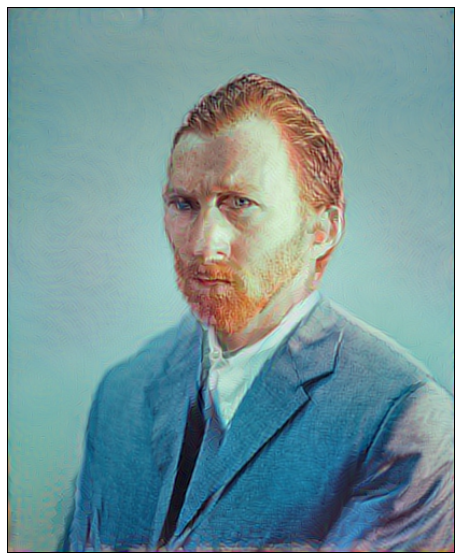

In [180]:
#paper 2 result figure4
plt.figure(figsize=(8,10))
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False) 
plt.imshow(deprocess(xs[-1]))
plt.imsave('paper2_3.png',deprocess(xs[-1]))

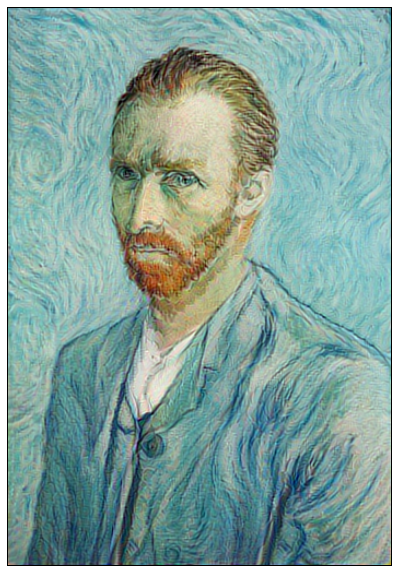

In [510]:
##paper 2 result figure4
plt.figure(figsize=(8,10))
plt.gca().xaxis.set_visible(False)    
plt.gca().yaxis.set_visible(False) 
plt.imshow(deprocess(xs[-1]))
plt.imsave('paper2_2.png',deprocess(xs[-1]))

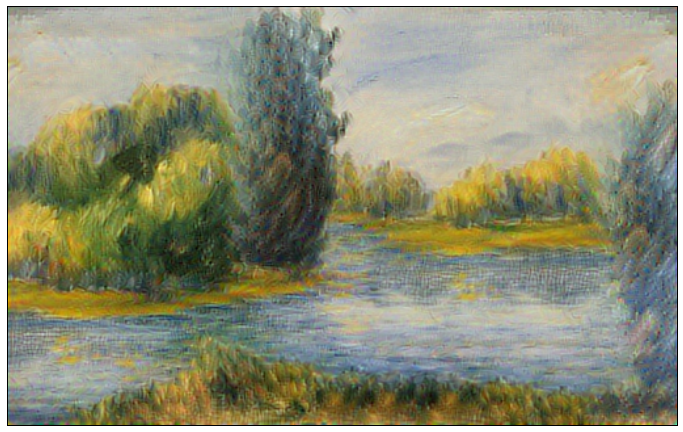

In [400]:
#result for landscape
plt.figure(figsize=(12,9))
plt.gca().xaxis.set_visible(False)    
plt.gca().yaxis.set_visible(False) 
plt.imshow(deprocess(xs[-1]))
plt.imsave('paper2_1.png',deprocess(xs[-1]))